# Learning with Prototypes

In [1]:
%load_ext autoreload
%autoreload 2

For this demo, we will require two additional modules from the cs771 package, a data generation module that will generate some toy data for us to play and experiment, and a data plotting module to plot the results nicely so that we can visualize how our algorithms are working.

In [2]:
import numpy as np
import numpy.linalg as lin
import time as t

from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd

**Generating Toy Data**: let us experiment with a toy dataset in d = 2 dimensions i.e. 2D with n = 20 points per class. Feel free to change n and see what happens. Changing d will cause issues with the plotting code though since it is only meant to plot 2D data.

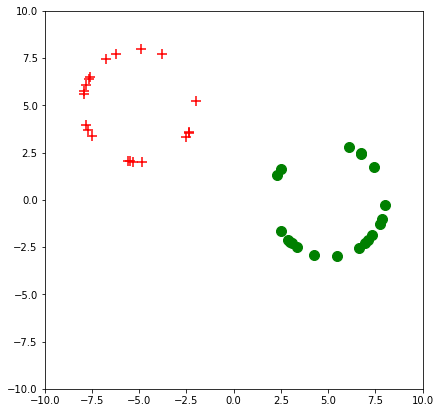

In [3]:
d = 2
n = 20

# Choose points around which positive and negative class points will be sampled
muPos = np.array( [-5,5] )
muNeg = np.array( [5,0] )

# Generate nice spherical data using our data generation module: first choose a nice radius
r = 3
XPos = gsd.genSphericalData( d, n, muPos, r )
XNeg = gsd.genSphericalData( d, n, muNeg, r )

# Let us plot these points on a plane and see where they landed
# First, obtain a new figure from the plotting module - the two arguments set the size of the figure
fig1 = pd.getFigure( 7, 7 )

# The three commands below are just to give the plot an aesthetic aspect ratio - do not worry about this
ax = fig1.add_axes( [0,0,0.75,0.75] )
ax.set_xlim( [-10, 10] )
ax.set_ylim( [-10, 10] )

# Now, plot the sampled points - you can change the color, marker and size of the markers
pd.plot2D( XPos, fig1, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig1, color = 'g', marker = 'o' )

**Implementing the LwP Classifier**: we will now implement the LwP classifier to try and classify this data.
1. First,  calculate prototypes for the two classes. This gives us our model
1. Next, define a method called LwP that can use this model to classify new points. This method will take in a single 2D data point and tells us which prototype was closer
1. Use the plotting module to shade the entire 2D space and visualize the _decision boundary_

**Decision Boundary**: for an ML classifier, the decision boundary is the set of points in whose neighborhood, the prediction given by the ML classifier fluctuates rapidly, for example, on one side of the boundary the classification is red and on the other side it is green. Every ML classifier (and we do really mean **every** ML classifier, even a deep learning classifier) has a decision boundary. Most of the time though, the decision boundary cannot be visualized or be obtained in the form of a simple equation. Decision boundaries get more complicated if there are more than two classes.

As we will notice, LwP is able to get perfect classification on the training data i.e. all red points are within the red shaded region and all green points are within the green shaded region. Thus, the _training error_ of the LwP classifier in this case is zero.

It took 3.78125 seconds to complete the shading 


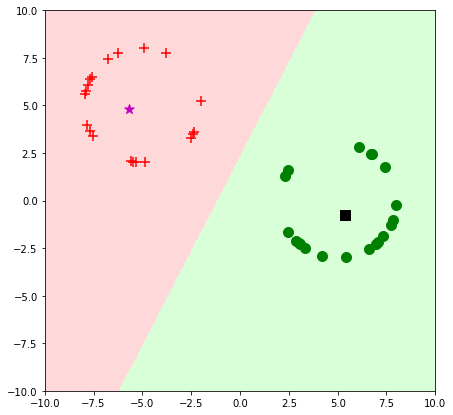

In [4]:
# Calculate the LwP model
protoPos = np.sum( XPos, 0 )/n
protoNeg = np.sum( XNeg, 0 )/n

# Define the LwP classifer -- note that x, y are scalars
def LwP( x, y ):
    return lin.norm( np.array( [x,y] ) - protoPos, 2 ) - lin.norm( np.array( [x,y] ) - protoNeg, 2 )

# Let us see what this classifier does i.e. where is its decision boundary
# Get another figure
fig2 = pd.getFigure( 7, 7 )

# Find out how much time are we taking to performa the shading
tic = t.process_time()
pd.shade2D( LwP, fig2, mode = 'point', xlim = 10, ylim = 10 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading ")
pd.plot2D( XPos, fig2, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'g', marker = 'o' )

# Plot the prototype locations as well to see where they lie w.r.t the decision boundary
pd.plot2DPoint( protoPos, fig2, color = 'm', marker = '*' )
pd.plot2DPoint( protoNeg, fig2, color = 'k', marker = 's' )

**Importance of Batch Processing in Python**: we will now develop a (much) faster version of the LwP classifier. This new version will take in an entire matrix of data points (instead of one point at a time) and use broadcasting to find the LwP decision on them all at once. In Python and other scripting languages processing data in batches is much faster than running a for loop that processes data one by one. In general, it is best to avoid loops (for/while) to do simple tasks in languages like Python. Instead, use in-built library function to do the same task. These in-built routines are frequently implemented in languages like C/C++ which are compiled and offer much faster processing.

It took 0.09375 seconds to complete the shading 


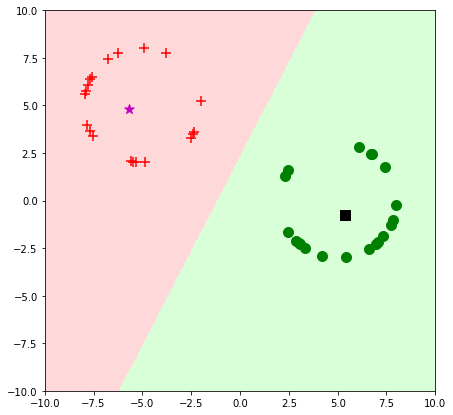

In [5]:
# This time, take in an entire 2D matrix of data points. This matrix has 2 columns, each row represents a test data point
def LwPBatch( X ):
    return lin.norm( X - protoPos, ord = 2, axis = 1 ) - lin.norm( X - protoNeg, ord = 2, axis = 1 )

fig3 = pd.getFigure( 7, 7 )

# Use the batch mode now - try running both point and batch mode to see that this version is 20-30 times faster :)
tic = t.process_time()
pd.shade2D( LwPBatch, fig3, mode = 'batch', xlim = 10, ylim = 10 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading ")
pd.plot2D( XPos, fig3, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'g', marker = 'o' )
pd.plot2DPoint( protoPos, fig3, color = 'm', marker = '*' )
pd.plot2DPoint( protoNeg, fig3, color = 'k', marker = 's' )

**Failure Case for LwP**: the LwP algorithm is very fast and straightforward to implement. Versions of the LwP algorithm are indeed used even in commercial applications where data is scarce (we will see examples later). However, the algorithm is not a very powerful one and can very easily be made to fail. In the following example, we will see that the LwP misclassifies some of the training examples.

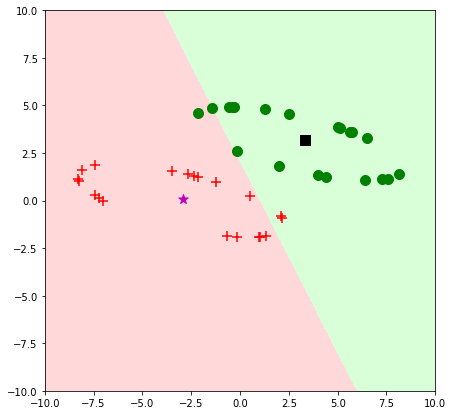

In [6]:
# Let us now generate data where LwP will fail
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )

# Since we have new data, we need to recalculate prototypes for the two classes
protoPos = np.sum( XPos, 0 )/n
protoNeg = np.sum( XNeg, 0 )/n

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( LwPBatch, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )
pd.plot2DPoint( protoPos, fig4, color = 'm', marker = '*' )
pd.plot2DPoint( protoNeg, fig4, color = 'k', marker = 's' )

**LwP with a Mahalanobis Metric**: we now use a cleverly designed Mahalanobis distance to fix the above problem. Note that the prototypes have not changed but rather the notion of "distance" has changed. In practice, this Mahalanobis metric would itself have to be learnt from the training data using _metric learning_ techniques. We will not study these techniques here but you are encouraged to discuss and look further in references if you are interested.

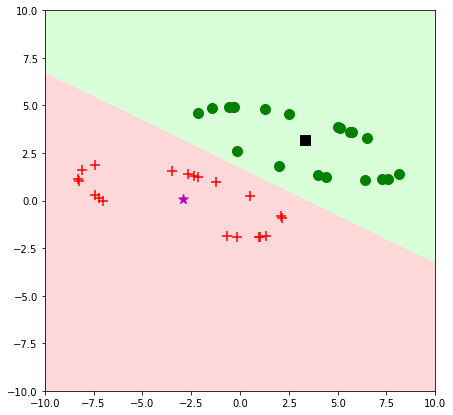

In [7]:
A = np.array( [[1/4, 1/4], [1/4, 1]] )
L = lin.cholesky( A )

# Recall that the Mahalanobis distance w.r.t. matrix A is merely the Euclidean distance between vectors
# transformed using L where A = LL'
def LwPMahlanobisBatch ( X ):
    return lin.norm( np.matmul( X - protoPos, L), ord = 2, axis = 1 ) - lin.norm( np.matmul( X - protoNeg, L), ord = 2, axis = 1 )

fig5 = pd.getFigure( 7, 7 )
pd.shade2D( LwPMahlanobisBatch, fig5, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig5, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig5, color = 'g', marker = 'o' )
pd.plot2DPoint( protoPos, fig5, color = 'm', marker = '*' )
pd.plot2DPoint( protoNeg, fig5, color = 'k', marker = 's' )